## Описание датасета

Датасет "Animals — dogs vs snakes", содержащий изображения собак и змей. Исходные данные разделены на две категории и распределены между обучающей и тестовой выборками в соотношении 80/20. Общий размер датасета составляет 2000 изображений: 1600 для обучения и 400 для тестирования.

## Код

Задача: построить сверточную нейронную сеть, которая будет распознавать животное, изображённое на картинке, и соответственно ставить объекту метку класса "собака" или "змея"

PyTorch

In [ ]:
!pip install torchview

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from torchview import draw_graph

Перед обучением все изображения приводем к размеру 150×150 пикселей, нормализуюем и преобразуюем в тензоры с использованием стандартных параметров нормализации

Генераторы данных:

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transforms_test = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
zip_path = '/content/drive/MyDrive/Animals - dogs vs snakes.zip'
with ZipFile(zip_path, 'r') as z:
    z.extractall('/content')

DATASET_DIR = os.path.join(LOCAL_DIR, "13. Animals - dogs vs snakes")
# Сохраняем пути к папкам в переменные TRAIN_DIR, TEST_DIR
TRAIN_DIR = os.path.join(LOCAL_DIR, "dataset/train")
TEST_DIR = os.path.join(LOCAL_DIR, "dataset/test")

for folder in [TRAIN_DIR, TEST_DIR]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

for category in ["dogs", "snakes"]:
    os.makedirs(os.path.join(TRAIN_DIR, category), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, category), exist_ok=True)

for category in ["dogs", "snakes"]:
    src = os.path.join(DATASET_DIR, category)
    images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg','.jpeg','.png'))]

    random.shuffle(images)

    split_idx = int(0.8 * len(images))

    for img in images[:split_idx]:
        shutil.copy2(os.path.join(src, img), os.path.join(TRAIN_DIR, category))

    for img in images[split_idx:]:
        shutil.copy2(os.path.join(src, img), os.path.join(TEST_DIR, category))

In [ ]:
# Создаем датасеты
dataset_train = datasets.ImageFolder(TRAIN_DIR, transform=transforms_train)
dataset_test  = datasets.ImageFolder(TEST_DIR,  transform=transforms_test)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
dataloader_test  = DataLoader(dataset_test,  batch_size=32, shuffle=False, num_workers=2)
print("Classes:", dataset_train.classes)

print("Train size:", len(dataset_train))
print("Test size:", len(dataset_test))

Classes: ['dogs', 'snakes']
Train size: 1600
Test size: 400


In [ ]:
class ScenesCNN(nn.Module):
    def __init__(self):
        super(ScenesCNN, self).__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.nn(x)
model = ScenesCNN()

In [ ]:
# Binary classification with a single output logit: criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss()
# Multi-class classification with N output logits: criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

def train_one_epoch(model, epoch, train_loader, test_loader, optimizer, criterion, device):
    model.train() # переводим модель в режим обучения, включая dropout и batchnorm слои
    total_loss, correct = 0, 0
    test_loss, test_correct = 0, 0

    progress = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    for images, labels in progress: # перебор обучающей выборки на одной эпохе
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # обнуление градиентов, которые остались с предыдущего шага

        outputs = model(images)# пропускаем данные батча через модель
        loss = criterion(outputs, labels.float().unsqueeze(1))# вычисляем функцию потерь
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels.float().unsqueeze(1)).sum().item()

        progress.set_postfix_str(
            f"Loss: {total_loss/len(train_loader):.4f}, "
            f"Acc: {correct/len(train_loader.dataset):.4f}"
        )
# Подсчет метрик и функции потерь на тестовой выборке после окончания эпохи
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            test_correct += (preds == labels.float().unsqueeze(1)).sum().item()

    return (
        total_loss / len(train_loader),
        correct / len(train_loader.dataset),
        test_loss / len(test_loader),
        test_correct / len(test_loader.dataset))

Using device: cpu


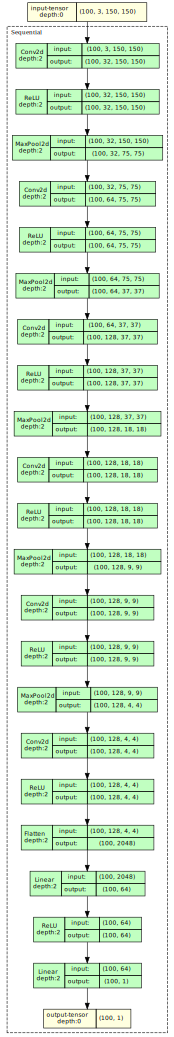

In [ ]:
model_pt = ScenesCNN()
model_graph = draw_graph(model_pt, input_size=(100, 3, 150, 150), expand_nested=True)
model_graph.visual_graph


Epoch 1/20 Train Loss: 0.6879, Acc: 0.5331 | Val Loss: 0.6655, Acc: 0.7250



Epoch 2/20 Train Loss: 0.5867, Acc: 0.7063 | Val Loss: 0.5722, Acc: 0.6925



Epoch 3/20 Train Loss: 0.4712, Acc: 0.7925 | Val Loss: 0.4429, Acc: 0.8000



Epoch 4/20 Train Loss: 0.3916, Acc: 0.8344 | Val Loss: 0.4189, Acc: 0.8050



Epoch 5/20 Train Loss: 0.3669, Acc: 0.8469 | Val Loss: 0.3878, Acc: 0.8425



Epoch 6/20 Train Loss: 0.3376, Acc: 0.8675 | Val Loss: 0.3824, Acc: 0.8400



Epoch 7/20 Train Loss: 0.3242, Acc: 0.8762 | Val Loss: 0.3553, Acc: 0.8375



Epoch 8/20 Train Loss: 0.3115, Acc: 0.8781 | Val Loss: 0.3541, Acc: 0.8600



Epoch 9/20 Train Loss: 0.3131, Acc: 0.8788 | Val Loss: 0.3462, Acc: 0.8650



Epoch 10/20 Train Loss: 0.2995, Acc: 0.8850 | Val Loss: 0.3271, Acc: 0.8650



Epoch 11/20 Train Loss: 0.2803, Acc: 0.8900 | Val Loss: 0.3200, Acc: 0.8725



Epoch 12/20 Train Loss: 0.2778, Acc: 0.8919 | Val Loss: 0.3410, Acc: 0.8700



Epoch 13/20 Train Loss: 0.2677, Acc: 0.8944 | Val Loss: 0.3259, Acc: 0.8825



Epoch 14/20 Train Loss: 0.2615, Acc: 0.9019 | Val Loss: 0.3107, Acc: 0.8900



Epoch 15/20 Train Loss: 0.2650, Acc: 0.8956 | Val Loss: 0.2997, Acc: 0.8750



Epoch 16/20 Train Loss: 0.2630, Acc: 0.8988 | Val Loss: 0.3340, Acc: 0.8675



Epoch 17/20 Train Loss: 0.2557, Acc: 0.9031 | Val Loss: 0.3051, Acc: 0.8950



Epoch 18/20 Train Loss: 0.2414, Acc: 0.9019 | Val Loss: 0.3242, Acc: 0.8675



Epoch 19/20 Train Loss: 0.2601, Acc: 0.8956 | Val Loss: 0.2924, Acc: 0.8875



Epoch 20/20 Train Loss: 0.2353, Acc: 0.9087 | Val Loss: 0.2982, Acc: 0.8800


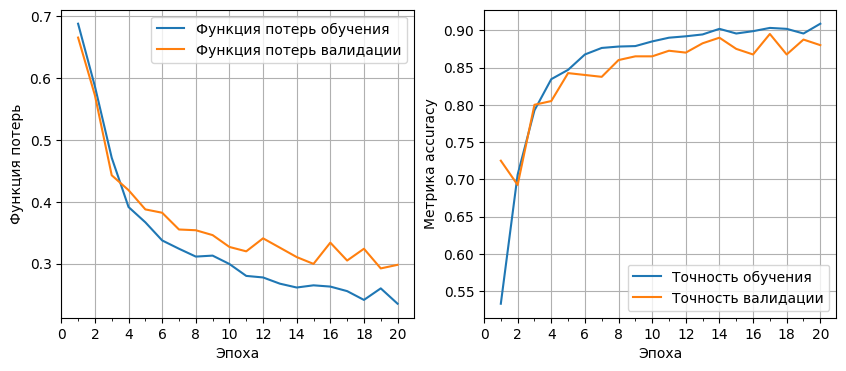

In [ ]:
EPOCHS = 20
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train_one_epoch(
        model, epoch, dataloader_train, dataloader_test, optimizer, criterion, device
    )

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_acc)
    history["val_accuracy"].append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS} "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.arange(1, EPOCHS + 1), history['loss'], label='Функция потерь обучения')
axs[0].plot(np.arange(1, EPOCHS + 1), history['val_loss'], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, EPOCHS + 1, 2))
axs[0].set_xticks(np.arange(0, EPOCHS + 1, 1), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, EPOCHS+ 1), history['accuracy'], label='Точность обучения')
axs[1].plot(np.arange(1, EPOCHS+ 1), history['val_accuracy'], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, EPOCHS + 1, 2))
axs[1].set_xticks(np.arange(0, EPOCHS + 1, 1), minor=True)
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.show()


Точность: 88.00%


<Figure size 600x600 with 0 Axes>

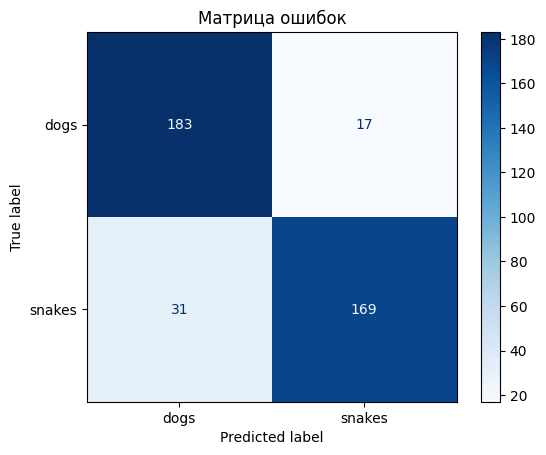

In [ ]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy()

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nТочность: {test_accuracy * 100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_train.classes)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок")
plt.show()

In [ ]:
def check_image(class_name, n=10):
    class_dir = os.path.join(TEST_DIR, class_name)
    files = sorted(os.listdir(class_dir))
    img_name = files[n-1]
    img_path = os.path.join(class_dir, img_name)

    print(f"\nПроверяется файл: {img_name} (категория {class_name})")

    image = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{class_name} — {img_name}")
    plt.show()

    transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0)
    device = next(model.parameters()).device
    img_tensor = img_tensor.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.sigmoid(output).item()

    predicted_class = "dogs" if pred < 0.5 else "snakes"

    print(f"Предсказание: {pred:.4f} → {predicted_class}")


Проверяется файл: 1_0026.jpg (категория dogs)


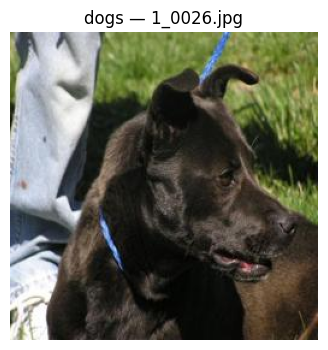

Предсказание: 0.1840 → dogs

Проверяется файл: 2_0534.jpg (категория snakes)


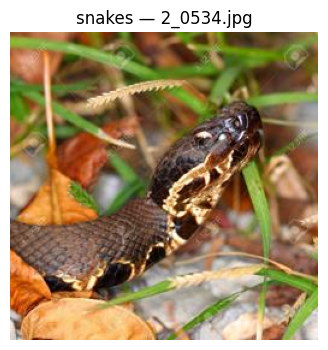

Предсказание: 0.9892 → snakes


In [ ]:
check_image("dogs", n=8)
check_image("snakes", n=111)